# 
By Sonja & Laura


### Observations

In our research we observed the effect of aging on the wine's taste and price, if price depends on wine's quality and the origin of the best rated wines.

### Contents
1) Data Import and Cleaning

2) Data Summary

3) Analysis

H1: 	Quality of wine depends on the year of its production. 
		The older the wine, the better it tastes.
- Points vs year
- Average points by year        
        
H2: 	Price is a strong indicator of quality. 
		The more expensive the wine, the better it tastes.
- Wine points by price
- Wine points by price (logscale)
- Wine points by price for wines under USD100        
        
H3: 	Older wines are more expensive.


H4: 	Old world wines are the gold standard. 
		Wines from France taste better.

## Conclusion



In [96]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from scipy.stats import sem
import json
import requests
import time
import urllib.parse

In [97]:
# Load file
file = "winemag-data-130K-v2.csv"

# Import API key
from api_keys import api_key

# Read Purchasing File and store into Pandas data frame
data = pd.read_csv(file)

data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [98]:
# Clean Data

# Extracting the year from the string with Python - Regular Expressions
years = []

for name in data['title']:
    matchObj = re.search( r'\b(19|20)\d{2}\b', name)
    if matchObj:
        years.append(matchObj.group())
    else:
        years.append("NaN") #Substituting missing values with "NaN"
        
data["year"] = years

# Remove unwanted columns
data = data.drop(["Unnamed: 0","region_1","taster_twitter_handle","region_2","description", "winery", "designation", "taster_name"], axis  = 1)

# Remove data with missing values
data = data[data["year"]!="NaN"]
data = data.dropna(how='any')

# Convert "year" values to integers
data["year"] = data["year"].astype(int)
data = data.loc[data["year"] >= 1934, :]

# Reset Index
data = data.reset_index()
data = data.drop(["index"], axis  = 1)

# Renaming wine "varieties" to merge together similar types
data['variety'] = data['variety'].replace({
                                     'Cabernet Franc' : 'Cabernet Sauvignon', 
                                     'Garnacha-Cabernet': 'Cabernet Sauvignon',
                                     'Shiraz' : 'Syrah & Shiraz',
                                     'Syrah' : 'Syrah & Shiraz',
                                     'Tempranillo Blend': 'Tempranillo',
                                     'Tempranillo-Merlot':'Tempranillo'
                                        })

# Create the bins and bin names for price data
bins = [0, 9.99, 19.99, 29.99, 39.99, 49.99, 74.99, 99.99, 249.99, 10000]
price_bins = ["<10", "10-20", "20-30", "30-40", "40-50", "50-75", "75-100", "100-250", ">250"]

data["price bin"] = pd.cut(data["price"], bins, labels=price_bins)

# Create the bins and bin names for points data
bins = [0, 85, 87, 88, 89, 90, 91, 95, 100]
points_bins = ["<86", "86-88", "89", "90", "91", "92-92", "92-96", "96-100"]

data["points bin"] = pd.cut(data["points"], bins, labels=points_bins)

# Append price per point
data["price per point"] = data["price"]/data["points"]

# Show data
data.head()

,country,points,price,province,title,variety,year,price bin,points bin,price per point
0,Portugal,87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,2011,10-20,86-88,0.172414
1,US,87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,2013,10-20,86-88,0.160920
2,US,87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,2013,10-20,86-88,0.149425
3,US,87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,2012,50-75,86-88,0.747126
4,Spain,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo,2011,10-20,86-88,0.172414


## Data Summary

In [99]:
# Create a DataFrame analyzing total results
    
##  To determine 'Number of Wines' use value_count function to count 'title'
count_title = data["title"].value_counts()

## To determine 'Average Purchase Price' use mean function to calculate the average of 'price'
average_price = data["price"].mean()

## To determine 'Average Purchase Points' use mean function to calculate the average of 'points'
average_points = data["points"].mean()

## To determine 'Number of countries' use value_countfunction to count 'country'
count_country = data["country"].value_counts()

## To determine 'Number of Tasters' use Pandas value_count function to count 'taster_name'
#count_taster_name = data["taster_name"].value_counts()

## To determine 'Number of Wineries' use Pandas value_count function to count 'winery'
#count_winery = data["winery"].value_counts()

## To determine 'Number of Variety' use Pandas value_count function to count 'variety'
count_variety = data["variety"].value_counts()

## To determine 'Oldest Wine' use Pandas min function on 'year'
min_year = data["year"].min()

## To determine 'Youngest Wine' use Pandas min function on 'year'
max_year = data["year"].max()

## Combine results into DataFrame for 'Analysis Total'
AnalysisTotal = pd.DataFrame({
    "Number of Wines": [len(count_title)],
    "Average Price": [average_price],
    "Average Points": [average_points],
    "Number of Countries": [len(count_country)],
    #"Number of Tasters": [len(count_taster_name)],
    #"Number of Wineries": [len(count_winery)],
    "Number of Varieties": [len(count_variety)],
    "Oldest Wine": [min_year],
    "Yongest Wine": [max_year]})

## 2.7 Clean Data - convert 'Average Price' and 'Total Revenue' to currency format
AnalysisTotal["Average Price"] = AnalysisTotal["Average Price"].map("$ {:,.2f}".format)
AnalysisTotal["Average Points"] = AnalysisTotal["Average Points"].map("{:,.0f}".format)
AnalysisTotal["Number of Wines"] = AnalysisTotal["Number of Wines"].map("{:,.0f}".format)

## 2.8 Print DataFrame
AnalysisTotal

,Number of Wines,Average Price,Average Points,Number of Countries,Number of Varieties,Oldest Wine,Yongest Wine
0,"107,336",$ 35.50,88,42,677,1934,2017


In [100]:
data.describe()

,points,price,year,price per point
count,116755.000000,116755.000000,116755.000000,116755.000000
mean,88.457582,35.503413,2010.734016,0.395344
std,3.045426,41.219720,3.655482,0.438194
min,80.000000,4.000000,1934.000000,0.046512
25%,86.000000,17.000000,2009.000000,0.195402
50%,88.000000,25.000000,2011.000000,0.290698
75%,91.000000,42.000000,2013.000000,0.472527
max,100.000000,3300.000000,2017.000000,37.500000


In [101]:
print(data.columns.values)

['country' 'points' 'price' 'province' 'title' 'variety' 'year'
 'price bin' 'points bin' 'price per point']


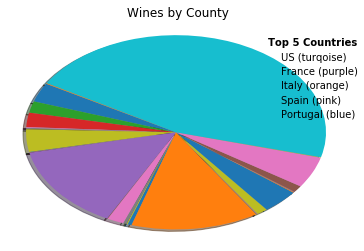

In [102]:
#Select Top Countries

# View Data by country
country_data = data[["country", "points"]]

data_0 = country_data.groupby(["country"]).count()
#data_1.sort_values(["price"], ascending=False)

#rename columns in dataframe
data_0.rename(columns={"points": "wine count"}).sort_values(["wine count"], ascending=False)

# Generate a list of countries with the most winse
country_list = data_0.index.tolist()

selected_country_list = []

for i in range(5):
    selected_country_list.append(country_list[i])
    
## Print selected couuntry list
#selected_country_list

# build pie chart
#explode = (0, 0, 0.1)
#colors = [np.random.rand(5,1)]

plt.figtext(.72, 0.8, 'Top 5 Countries', fontweight = 'bold')
plt.figtext(.75, 0.75, 'US (turqoise)')
plt.figtext(.75, 0.7, 'France (purple)')
plt.figtext(.75, 0.65, 'Italy (orange)')
plt.figtext(.75, 0.6, 'Spain (pink)')
plt.figtext(.75, 0.55, 'Portugal (blue)')
 
    
plt.pie(data_0, #labels=data_0.index.values, #colors=colors,  #explode=explode
        #autopct="%1.1f%%", 
        shadow=True, startangle=150, frame=False)

plt.title("Wines by County")
plt.axis("auto")

# Save image and print the final product to the screen
plt.savefig("Wines by Country.png")
plt.show()

## H1: Quality of wine depends on the year of it's production. The older the wine, the better it tastes.

### Points vs Year

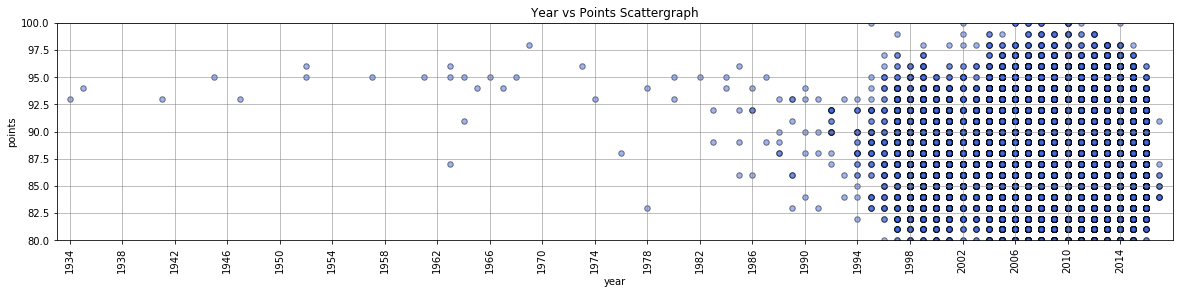

In [119]:
# Set figure size
plt.figure(figsize=(20,4))

#Plot the year vs points data_years

plt.scatter(data["year"],
            data["points"],
            facecolors='royalblue', edgecolors="black", alpha=0.5,
            label = data["title"],
            marker= "o", linewidth=1, 
            s= 30)
    
# Incorporate the other graph properties
plt.title("Year vs Points Scattergraph")
plt.xlabel("year")
plt.ylabel("points")
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.xlim(left= data["year"].min()-1, right= data["year"].max()+1)
plt.ylim(bottom= data["points"].min(), top= data["points"].max())
plt.xticks(np.arange(data['year'].min(),data['year'].max(), step=4),
           rotation="vertical") 

# Save Figure
plt.savefig("Year vs Points (Scattergraph).png")

# Show plot
plt.show()

### Average points by year

In [104]:
# Store the Wine Grouped by Year
grouped_data = data.groupby(["year"])

# Calculate mean points
mean_points = grouped_data[["points"]].mean()

# Append count of wines to the dataframe
mean_points["wine count"] = grouped_data[["title"]].count()

# Convert to DataFrame
mean_points_df = mean_points.reset_index()

# Preview DataFrame
mean_points_df.head()

,year,points,wine count
0,1934,93.0,1
1,1935,94.0,1
2,1941,93.0,1
3,1945,95.0,1
4,1947,93.0,1


In [105]:
# Store the Standard Error associated with Wine Grouped by Year, and country
StdErr_mean_points = grouped_data[["points"]].sem()

# Append count of wines to the dataframe
StdErr_mean_points["wine count"] = grouped_data[["title"]].count()

# Convert to DataFrame
StdErr_mean_points_df = StdErr_mean_points.reset_index()

# Preview DataFrame
StdErr_mean_points_df.head()

,year,points,wine count
0,1934,NaN,1
1,1935,NaN,1
2,1941,NaN,1
3,1945,NaN,1
4,1947,NaN,1


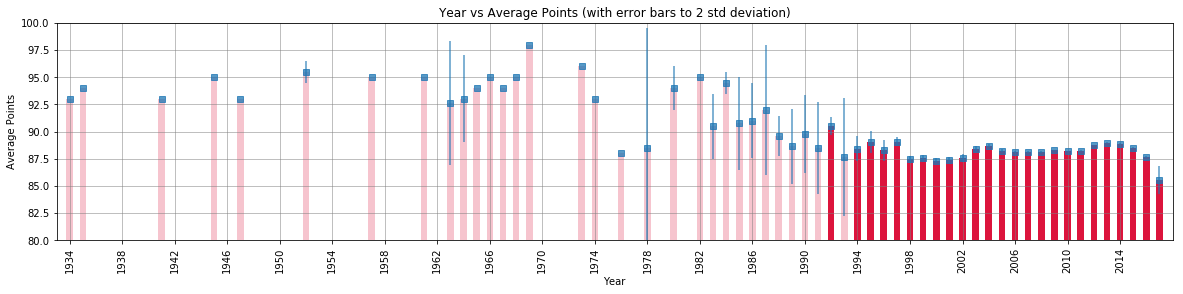

In [106]:
#Split data into years with >5 wines vs multiple
five_or_less = mean_points_df.loc[mean_points_df['wine count'] <= 10, :]
six_or_more = mean_points_df.loc[mean_points_df['wine count'] >= 11, :]

# Set figure size
plt.figure(figsize=(20,4))

# Plot bar graph

six_or_more_results =plt.bar(list(six_or_more["year"].values), 
                              six_or_more["points"],
                              color='crimson',
                              alpha= 1,
                              align="center", 
                              width=.5,
                              label= six_or_more["points"])

five_or_less_results =plt.bar(list(five_or_less["year"].values), 
                              five_or_less["points"],
                              color='crimson',
                              alpha= .25,
                              align="center", 
                              width=.5,
                              label= five_or_less["points"])

plt.errorbar(list(mean_points_df["year"].values), 
             mean_points_df["points"], 
             StdErr_mean_points_df["points"]*2,
             fmt="s",
             alpha= .75)


# Format bar graph
plt.title("Year vs Average Points (with error bars to 2 std deviation)")
plt.ylabel("Average Points")
plt.xlabel("Year")
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.ylim(80, 100)
plt.xlim(mean_points_df['year'].min()-1, mean_points_df['year'].max()+1)
plt.xticks(np.arange(mean_points_df['year'].min(),mean_points_df['year'].max(), step=4),
           rotation="vertical") 

#plt.legend(loc="best", fontsize="small", fancybox=True)

#Save the Figure
plt.savefig("Year vs Average Points.png")

# Show the Figure
plt.show()

## H2: Quality of wine depends on price. The more expensive the wine, the better it tastes.¶

### Wine Points by Price (all)

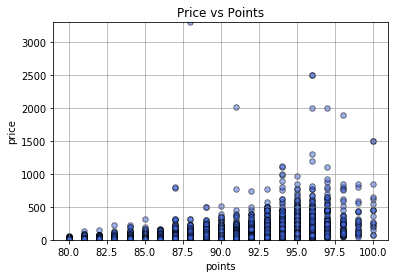

In [107]:
#Plot the price vs points data

plt.scatter(data["points"],
            data["price"],  
            facecolors='royalblue', edgecolors="black", alpha=0.5,
            label = data["title"],
            marker= "o", linewidth=1, 
            s= 30)
    
# Incorporate the other graph properties
plt.title("Price vs Points")
plt.xlabel("points")
plt.ylabel("price")
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.xlim(left= data["points"].min()-1, right= data["points"].max()+1)
plt.ylim(bottom= data["price"].min(), top= data["price"].max())

# Save Figure
plt.savefig("Price vs Points.png")

# Show plot
plt.show()

### Wine Points by Price (all, logscale)

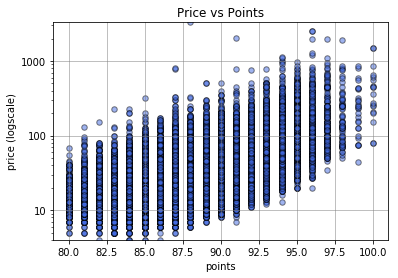

In [108]:
#Plot the price vs points data

fig, ax = plt.subplots()

plt.scatter(data["points"],
            data["price"],  
            facecolors='royalblue', edgecolors="black", alpha=0.5,
            label = data["title"],
            marker= "o", linewidth=1, 
            s= 30)
    
# Incorporate the other graph properties
plt.title("Price vs Points")
plt.xlabel("points")
plt.ylabel("price (logscale)")
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.xlim(left= data["points"].min()-1, right= data["points"].max()+1)
plt.ylim(bottom= data["price"].min(), top= data["price"].max())
plt.yscale('log')

from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())

# Save Figure
plt.savefig("Price (logscale) vs Points.png")

# Show plot
plt.show()

### Wine Points by Price (under USD100)

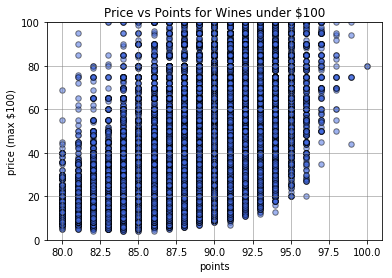

In [109]:
#Plot the price vs points data

plt.scatter(data["points"],
            data["price"],  
            facecolors='royalblue', edgecolors="black", alpha=0.5,
            label = data["title"],
            marker= "o", linewidth=1, 
            s= 30)
    
# Incorporate the other graph properties
plt.title("Price vs Points for Wines under $100")
plt.xlabel("points")
plt.ylabel("price (max $100)")
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.xlim(left= data["points"].min()-1, right= data["points"].max()+1)
plt.ylim(bottom= 0, top= 100)

# Save Figure
plt.savefig("Price vs Points for Wines under USD100.png")

# Show plot
plt.show()

## H3: Quality of wine depends on the region it's from. French wines are the best.¶

In [110]:
# Store the Wine Grouped by Year
grouped_country_data = data.groupby(["country"])

# Calculate mean points
mean_points_by_country = grouped_country_data[["points"]].mean()

# Append count of wines, as well as the points for the higest and lowest rated wines to the dataframe
mean_points_by_country["wine count"] = grouped_country_data[["title"]].count()
mean_points_by_country["max points"] = grouped_country_data[["points"]].max()
mean_points_by_country["min points"] = grouped_country_data[["points"]].min()

# Append std error of points average to the  dataframe
mean_points_by_country["std error points avg"] = grouped_country_data[["points"]].sem()

# Convert to DataFrame
mean_points_by_country_df = mean_points_by_country.reset_index().sort_values(["points"], ascending=False)

# Preview DataFrame
mean_points_by_country_df.head()

,country,points,wine count,max points,min points,std error points avg
13,England,91.709091,55,95,89,0.241589
19,India,90.222222,9,93,87,0.571979
3,Austria,90.210774,2766,97,82,0.046586
16,Germany,89.843631,2104,98,81,0.053868
7,Canada,89.379447,253,94,82,0.150889


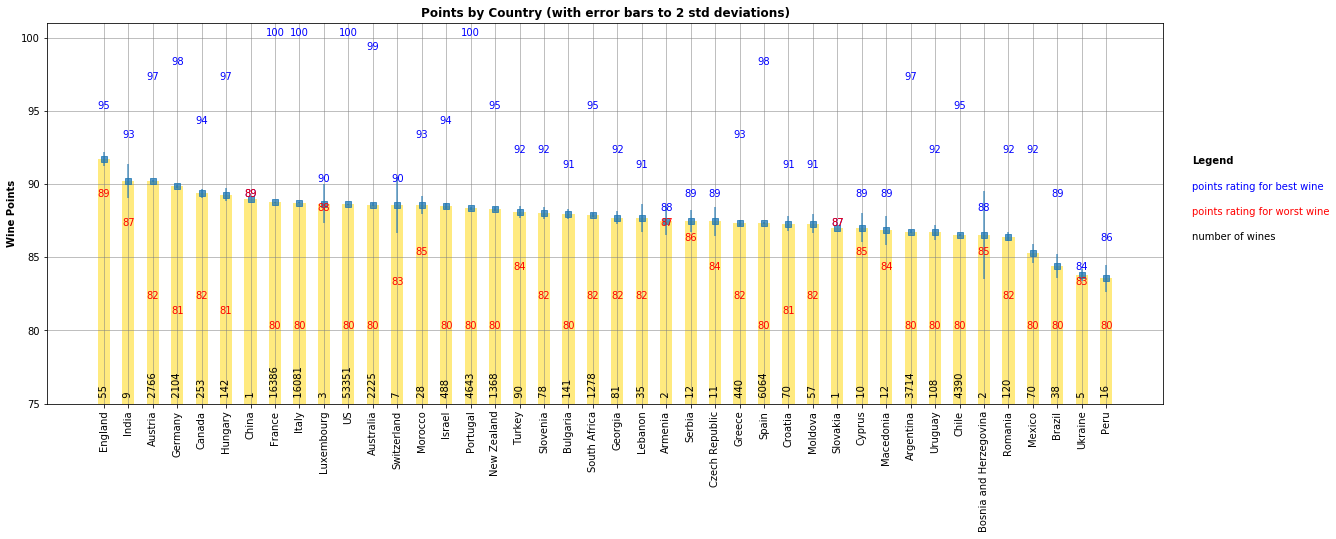

In [111]:
plt.figure(figsize=(20,7))

country_results =plt.bar(list(mean_points_by_country_df['country'].values), 
                         mean_points_by_country_df['points'],
                         color='gold',
                         alpha= .5,
                         align="center", 
                         width=.5,
                         label= mean_points_by_country_df['points']
                        )

plt.errorbar(list(mean_points_by_country_df['country'].values), 
             mean_points_by_country_df['points'], 
             mean_points_by_country_df['std error points avg']*2,
             fmt="s",
             alpha= .75)

# Use functions to label the bar graph
wine_count = mean_points_by_country_df['wine count'].tolist()
max_list = mean_points_by_country_df['max points'].tolist()
min_list = mean_points_by_country_df['min points'].tolist()

def label(bars):
    
    for bar in bars:
        i = int(bar.get_x()+.25)
        wc = wine_count[i]
        ma = max_list[i]
        mi = min_list[i]
        height = bar.get_height()
        
#         plt.text(bar.get_x() + bar.get_width()/2.,height,
#                 f"{int(height)}",
#                 ha='center', va='bottom', color='red')
        
        plt.text(bar.get_x() + bar.get_width()/2.,ma,
                f"{ma}",
                ha='center', va='bottom', color='blue')
        
        plt.text(bar.get_x() + bar.get_width()/2.,mi,
                f"{mi}",
                ha='center', va='bottom', color='red')
        
        plt.text(bar.get_x() + bar.get_width()/2.,75,
                f"  {wc}",
                ha='center', va='bottom', color='black', rotation='vertical')
            
# Call function
label(country_results)

# Format bar graph
plt.title("Points by Country (with error bars to 2 std deviations)", fontweight='bold')
plt.ylabel("Wine Points", fontweight='bold')
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.ylim(75, 101)
plt.xticks(rotation="vertical")

# Incorporate a text Leged
plt.figtext(.92, 0.6, 'Legend', fontweight='bold')
plt.figtext(.92, 0.55, 'points rating for best wine', color = 'blue')
#plt.figtext(.92, 0.5, 'points rating for average wine', color = 'red')
plt.figtext(.92, 0.5, 'points rating for worst wine', color = 'red')
plt.figtext(.92, 0.45, 'number of wines', color = 'black')

#Save the Figure
plt.savefig("Points by Country.png")

# Show the Figure
plt.show()

### 99 and 100 point wines by price

In [22]:
best_rated_wines = data.loc[(data["points"] >= 99),:]

organized_best_rated_wines = best_rated_wines[["points","title","variety", "country", "province","price"]]

organized_best_rated_wines.sort_values(["price"], ascending =True).head(8)

,points,title,variety,country,province,price
105964,99,Failla 2010 Estate Vineyard Chardonnay (Sonoma...,Chardonnay,US,California,44.0
42884,99,Cayuse 2011 En Chamberlin Vineyard Syrah (Wall...,Syrah & Shiraz,US,Oregon,75.0
42463,99,Williams Selyem 2010 Hirsch Vineyard Pinot Noi...,Pinot Noir,US,California,75.0
42462,99,Cayuse 2009 En Chamberlin Vineyard Syrah (Wall...,Syrah & Shiraz,US,Oregon,75.0
102224,100,Charles Smith 2006 Royal City Syrah (Columbia ...,Syrah & Shiraz,US,Washington,80.0
110940,100,Cayuse 2008 Bionic Frog Syrah (Walla Walla Val...,Syrah & Shiraz,US,Washington,80.0
1417,99,Williams Selyem 2009 Precious Mountain Vineyar...,Pinot Noir,US,California,94.0
115245,99,Trefethen 2005 Reserve Cabernet Sauvignon (Oak...,Cabernet Sauvignon,US,California,100.0


### What country provides the best value wines?

In [23]:
# Append average price per point as well as max and min average prices per point dataframe
mean_points_by_country["average price per point"] = grouped_country_data[["price per point"]].mean()
mean_points_by_country["max price per point"] = grouped_country_data[["price per point"]].max()
mean_points_by_country["min price per point"] = grouped_country_data[["price per point"]].min()

# Append std error of points average to the  dataframe
mean_points_by_country["std error average price per point"] = grouped_country_data[["price per point"]].sem()

# Convert to DataFrame
mean_points_by_country_df2 = mean_points_by_country.reset_index().sort_values(["average price per point"], ascending=True)

# Preview DataFrame
mean_points_by_country_df2.head()

,country,points,wine count,max points,min points,std error points avg,average price per point,max price per point,min price per point,std error average price per point
40,Ukraine,83.800000,5,84,83,0.200000,0.105135,0.156627,0.071429,0.020643
4,Bosnia and Herzegovina,86.500000,2,88,85,1.500000,0.144652,0.152941,0.136364,0.008289
19,India,90.222222,9,93,87,0.571979,0.147356,0.215054,0.111111,0.012584
1,Armenia,87.500000,2,88,87,0.500000,0.165687,0.170455,0.160920,0.004768
6,Bulgaria,87.936170,141,91,80,0.174984,0.165714,1.111111,0.091954,0.008827


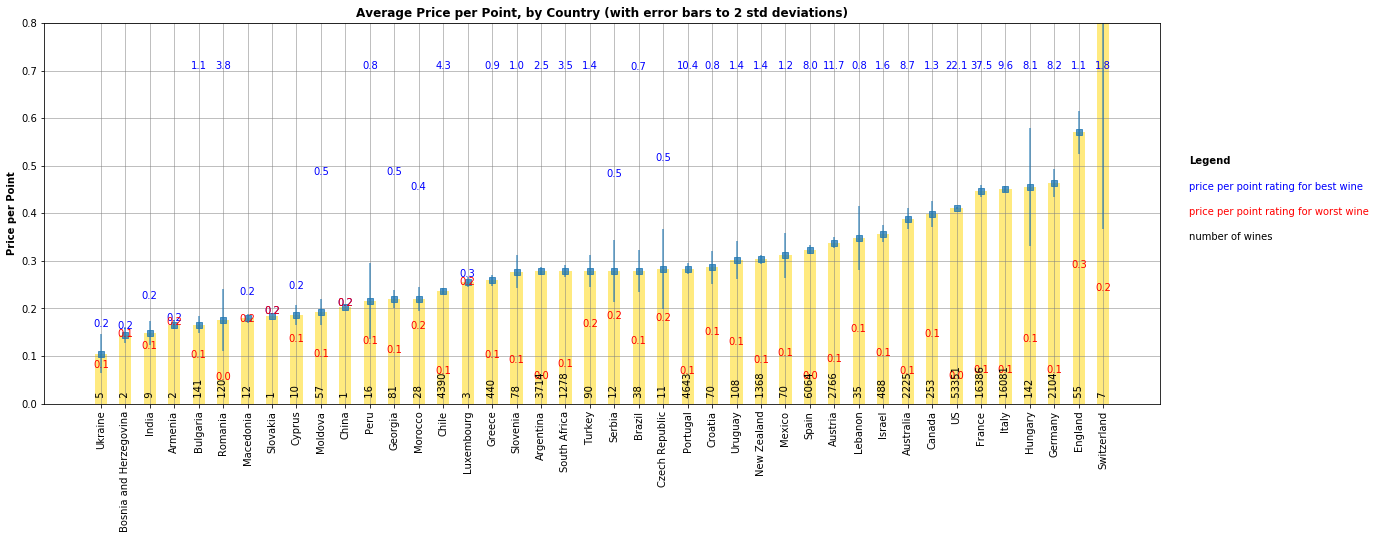

In [24]:
plt.figure(figsize=(20,7))

country_results =plt.bar(list(mean_points_by_country_df2['country'].values), 
                         mean_points_by_country_df2['average price per point'],
                         color='gold',
                         alpha= .5,
                         align="center", 
                         width=.5,
                         label= mean_points_by_country_df2['average price per point']
                        )

plt.errorbar(list(mean_points_by_country_df2['country'].values), 
             mean_points_by_country_df2['average price per point'], 
             mean_points_by_country_df2['std error average price per point']*2,
             fmt="s",
             alpha= .75)

# Use functions to label the bar graph
wine_count_2    = mean_points_by_country_df2['wine count'].tolist()
max_ppp_list    = mean_points_by_country_df2['max price per point'].tolist()
min_ppp_list    = mean_points_by_country_df2['min price per point'].tolist()
avg_points_list = mean_points_by_country_df2['points'].tolist()

def label(bars):
    
    for bar in bars:
        i = int(bar.get_x()+.25)
        wc2 = wine_count_2[i]
        ma_ppp = max_ppp_list[i]
        mi_ppp = min_ppp_list[i]
        avg_p = avg_points_list[i]
        height = bar.get_height()
        
#         plt.text(bar.get_x() + bar.get_width()/2.,height,
#                 f"{int(height)}",
#                 ha='center', va='bottom', color='red')
        
#         plt.text(bar.get_x() + bar.get_width()/2.,.15,
#                 f"{round(avg_p,1)}",
#                 ha='center', va='bottom', color='red', rotation='vertical')
        
        plt.text(bar.get_x() + bar.get_width()/2.,
                 min(ma_ppp, .7),
                 f"{round(ma_ppp,1)}",
                 ha='center', va='bottom', color='blue')
        
        plt.text(bar.get_x() + bar.get_width()/2.,mi_ppp,
                f"{round(mi_ppp,1)}",
                ha='center', va='bottom', color='red')
        
        plt.text(bar.get_x() + bar.get_width()/2.,0,
                f"  {wc2}",
                ha='center', va='bottom', color='black', rotation='vertical')
            
# Call function
label(country_results)

# Format bar graph
plt.title("Average Price per Point, by Country (with error bars to 2 std deviations)", fontweight='bold')
plt.ylabel("Price per Point", fontweight='bold')
plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.ylim(0, .8)
plt.xticks(rotation="vertical")

# Incorporate a text Leged
plt.figtext(.92, 0.6, 'Legend', fontweight='bold')
plt.figtext(.92, 0.55, 'price per point rating for best wine', color = 'blue')
#plt.figtext(.92, 0.5, 'average points rating', color = 'red')
#plt.figtext(.92, 0.45, 'price per point rating for average', color = 'red')
plt.figtext(.92, 0.5, 'price per point rating for worst wine', color = 'red')
plt.figtext(.92, 0.45, 'number of wines', color = 'black')

#Save the Figure
plt.savefig("Average Price per Point, by Country.png")

# Show the Figure
plt.show()

### What are the best value wines?

In [178]:
best_value_wines = data.loc[(data["price per point"] <= 0.2),:]
best_value_wines_90 = best_value_wines.loc[(data["points"] >= 90),:]

organized_best_value_wines_90 = best_value_wines_90[["price per point", "points","title","variety", "country", "province","price"]]

organized_best_value_wines_90.sort_values(["price per point"], ascending =True).head(17)

,price per point,points,title,variety,country,province,price
31032,0.076923,91,Herdade dos Machados 2012 Toutalga Red (Alente...,Portuguese Red,Portugal,Alentejano,7.0
23340,0.087912,91,Snoqualmie 2006 Winemaker's Select Riesling (C...,Riesling,US,Washington,8.0
68019,0.088889,90,Rothbury Estate 2001 Chardonnay (South Eastern...,Chardonnay,Australia,Australia Other,8.0
63375,0.088889,90,Aveleda 2013 Quinta da Aveleda Estate Bottled ...,Portuguese White,Portugal,Minho,8.0
4641,0.088889,90,Esser Cellars 2001 Chardonnay (California),Chardonnay,US,California,8.0
39367,0.098901,91,Chateau Ste. Michelle 2010 Dry Riesling (Colum...,Riesling,US,Washington,9.0
51113,0.098901,91,Barnard Griffin 2012 Fumé Blanc Sauvignon Blan...,Sauvignon Blanc,US,Washington,9.0
9326,0.098901,91,Chateau Ste. Michelle 2011 Riesling (Columbia ...,Riesling,US,Washington,9.0
89880,0.100000,90,DFJ Vinhos 2012 Paxis Red (Lisboa),Portuguese Red,Portugal,Lisboa,9.0
28039,0.100000,90,Rendition 2007 Petite Sirah (Alexander Valley),Petite Sirah,US,California,9.0


TypeError: 'numpy.ndarray' object is not callable

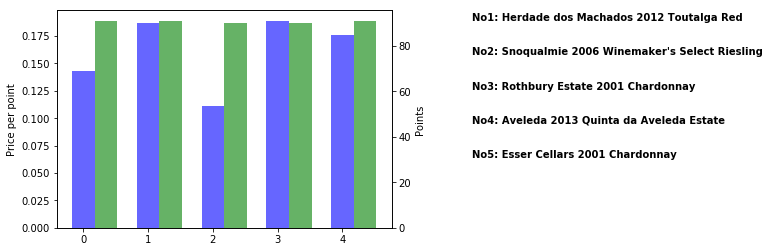

In [200]:

width =0.5
n_groups = 5

price_per_point = organized_best_value_wines_90["price per point"].head()
points = organized_best_value_wines_90["points"].head()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

ax1 = ax.twinx()

rects1 = ax.bar(index, price_per_point, bar_width,
                alpha=opacity, color='b',
                label='Price per point')

rects2 = ax1.bar(index + bar_width, points, bar_width,
                alpha=opacity, color='g',
                label='Points')

plt.text(6,90,'No1: Herdade dos Machados 2012 Toutalga Red', ha='left', va='bottom', color='black', fontweight='bold')
plt.text(6,75,"No2: Snoqualmie 2006 Winemaker's Select Riesling",ha='left', va='bottom', color='black', fontweight='bold')
plt.text(6,60,'No3: Rothbury Estate 2001 Chardonnay',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(6,45,'No4: Aveleda 2013 Quinta da Aveleda Estate',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(6,30,'No5: Esser Cellars 2001 Chardonnay',ha='left', va='bottom', color='black', fontweight='bold')
    
plt.ylabel("Points")
ax.set_ylabel('Price per point')
plt.ax(np.arange(0, 1, 0.1))
plt.title('Best wines to buy')
plt.yticks(np.arange(0, 100, 10))
plt.xticks(ind, ('No1', 'No2', 'No3', 'No4', 'No5'))
plt.legend((rects1[0], rects2[0]), ('Price per point', 'Points'), loc = "upper right")
plt.xticks(rotation="vertical")

  # instantiate a second axes that shares the same x-axis

plt.savefig("Best value wines.png")
plt.show()


### What are the best wines under USD 30?

In [136]:
top_rated_wines = data.loc[(data["points"] >= 96),:]
wines_to_buy = top_rated_wines.loc[(data["price"] <= 30),:]

organized_wines_to_buy = wines_to_buy[["points","title","variety", "country", "province","price"]]

organized_wines_to_buy.sort_values(["points" , "price"], ascending= [False, True])

,points,title,variety,country,province,price
91161,96,Rulo 2007 Syrah (Columbia Valley (WA)),Syrah & Shiraz,US,Washington,20.0
36095,96,Isole e Olena 2010 Chianti Classico,Red Blend,Italy,Tuscany,27.0
48663,96,Donkey & Goat 2012 Grenache Noir Grenache (El ...,Grenache,US,California,27.0
92003,96,The Eyrie Vineyards 2014 Estate Chardonnay (Du...,Chardonnay,US,Oregon,27.0
41152,96,Château Filhot 2014 Sauternes,Bordeaux-style White Blend,France,Bordeaux,28.0
48715,96,Eichinger 2014 Gaisberg Reserve Riesling (Kamp...,Riesling,Austria,Kamptal,28.0
8906,96,Domaines Schlumberger 2014 Saering Grand Cru R...,Riesling,France,Alsace,29.0
73490,96,Efeste 2009 Lola Chardonnay (Columbia Valley (...,Chardonnay,US,Washington,30.0
98587,96,Sineann 2015 TFL Pinot Noir (Willamette Valley),Pinot Noir,US,Oregon,30.0


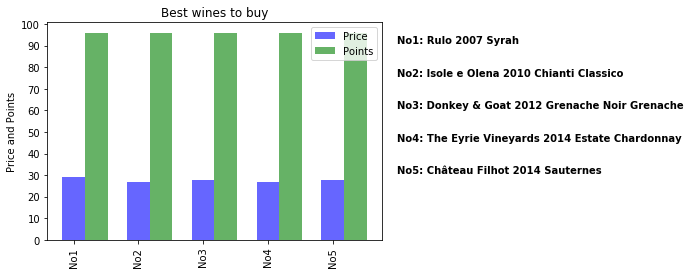

In [153]:
# data to plot


width =0.5
n_groups = 5

price = organized_wines_to_buy["price"].head()
points = organized_wines_to_buy["points"].head()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = ax.bar(index, price, bar_width,
                alpha=opacity, color='b',
                label='Price')

rects2 = ax.bar(index + bar_width, points, bar_width,
                alpha=opacity, color='g',
                label='Points')

plt.text(5,90,'No1: Rulo 2007 Syrah', ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,75,'No2: Isole e Olena 2010 Chianti Classico',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,60,'No3: Donkey & Goat 2012 Grenache Noir Grenache',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,45,'No4: The Eyrie Vineyards 2014 Estate Chardonnay',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,30,'No5: Château Filhot 2014 Sauternes',ha='left', va='bottom', color='black', fontweight='bold')
    
plt.ylabel('Price and Points')
plt.title('Best wines to buy')
plt.yticks(np.arange(0, 110, 10))
plt.xticks(ind, ('No1', 'No2', 'No3', 'No4', 'No5'))
plt.legend((rects1[0], rects2[0]), ('Price', 'Points'), loc = "upper right")
plt.xticks(rotation="vertical")


plt.savefig("Best wines for under 30 $.png")
plt.show()





### What are the best wines under USD100?

In [28]:
top_rated_wines = data.loc[(data["points"] >= 98),:]
wines_to_buy = top_rated_wines.loc[(data["price"] <= 100),:]

organized_wines_to_buy = wines_to_buy[["points","title","variety", "country", "province","price"]]

organized_wines_to_buy.sort_values(["points", "price"], ascending = [False, True]).head(30)

,points,title,variety,country,province,price
102224,100,Charles Smith 2006 Royal City Syrah (Columbia ...,Syrah & Shiraz,US,Washington,80.0
110940,100,Cayuse 2008 Bionic Frog Syrah (Walla Walla Val...,Syrah & Shiraz,US,Washington,80.0
105964,99,Failla 2010 Estate Vineyard Chardonnay (Sonoma...,Chardonnay,US,California,44.0
42462,99,Cayuse 2009 En Chamberlin Vineyard Syrah (Wall...,Syrah & Shiraz,US,Oregon,75.0
42463,99,Williams Selyem 2010 Hirsch Vineyard Pinot Noi...,Pinot Noir,US,California,75.0
42884,99,Cayuse 2011 En Chamberlin Vineyard Syrah (Wall...,Syrah & Shiraz,US,Oregon,75.0
1417,99,Williams Selyem 2009 Precious Mountain Vineyar...,Pinot Noir,US,California,94.0
115245,99,Trefethen 2005 Reserve Cabernet Sauvignon (Oak...,Cabernet Sauvignon,US,California,100.0
1420,98,Pirouette 2008 Red Wine Red (Columbia Valley (...,Bordeaux-style Red Blend,US,Washington,50.0
105127,98,Gramercy 2010 Lagniappe Syrah (Columbia Valley...,Syrah & Shiraz,US,Washington,55.0


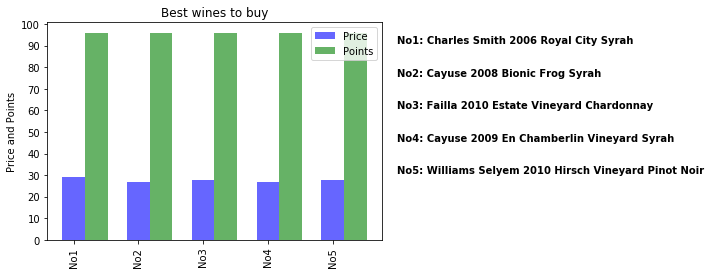

In [155]:
width =0.5
n_groups = 5

price = organized_wines_to_buy["price"].head()
points = organized_wines_to_buy["points"].head()

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = ax.bar(index, price, bar_width,
                alpha=opacity, color='b',
                label='Price')

rects2 = ax.bar(index + bar_width, points, bar_width,
                alpha=opacity, color='g',
                label='Points')

plt.text(5,90,'No1: Charles Smith 2006 Royal City Syrah', ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,75,'No2: Cayuse 2008 Bionic Frog Syrah',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,60,'No3: Failla 2010 Estate Vineyard Chardonnay',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,45,'No4: Cayuse 2009 En Chamberlin Vineyard Syrah',ha='left', va='bottom', color='black', fontweight='bold')
plt.text(5,30,'No5: Williams Selyem 2010 Hirsch Vineyard Pinot Noir',ha='left', va='bottom', color='black', fontweight='bold')
    
plt.ylabel('Price and Points')
plt.title('Best wines to buy')
plt.yticks(np.arange(0, 110, 10))
plt.xticks(ind, ('No1', 'No2', 'No3', 'No4', 'No5'))
plt.legend((rects1[0], rects2[0]), ('Price', 'Points'), loc = "upper right")
plt.xticks(rotation="vertical")


plt.savefig("Best wines for under 100 $.png")
plt.show()

# # Other

# Weather influence on wine quality

In [120]:
# Store the Wine Grouped by Province
grouped_province_data = data.groupby(["province"])

# Calculate mean points
mean_points_by_province = grouped_province_data[["points"]].mean()

# Append count of wines, as well as the points for the higest and lowest rated wines to the dataframe
mean_points_by_province["wine count"] = grouped_province_data[["title"]].count()
mean_points_by_province["max points"] = grouped_province_data[["points"]].max()
mean_points_by_province["min points"] = grouped_province_data[["points"]].min()

# Append std error of points average to the  dataframe
mean_points_by_province["std error points avg"] = grouped_province_data[["points"]].sem()
mean_points_by_province = mean_points_by_province.loc[(mean_points_by_province["wine count"] >= 100),:]
best_rated_wines = data.loc[(data["points"] >= 99),:]

# Convert to DataFrame
mean_points_by_province_df = mean_points_by_province.reset_index().sort_values(["points"], ascending=False)

# Preview DataFrame
mean_points_by_province_df.head()

,province,points,wine count,max points,min points,std error points avg
19,Champagne,92.310870,460,100,83,0.110339
75,Wachau,91.665584,308,96,85,0.146759
56,Port,91.440945,254,100,84,0.180885
31,Kamptal,91.396450,338,96,85,0.117734
59,Rheingau,90.993506,308,98,85,0.137972


In [121]:
weather_data = []

province = ["Champagne", "Wachau", "Port", "Kamptal", "Rheingau", "Rapel Valley", "Maule Valley", "Michigan", "Limarí Valley", "Casablanca Valley"]
cities = ["Reims", "Melk", "Porto", "Langenlois", "Wiesbaden", "Rapel", "Melk", "Muskegon", "Ovalle", "Quilpue"]


url = "http://api.openweathermap.org/data/2.5/weather?"

for city in cities:
    
    query_url = f"{url}q={city}&appid={api_key}"
    weather_response = requests.get(query_url).json()

    try:
        city_data = [weather_response["name"], 
                     weather_response["sys"]["country"],
                     weather_response["main"]["temp"],
                     weather_response["main"]["humidity"]]
                    
        weather_data.append(city_data)
        
        print(f"Processing Record {cities.index(city)} | {weather_response['name']}")
    except (KeyError, IndexError):
        print("City not found. Skipping...")

Processing Record 0 | Reims
Processing Record 1 | Melk
Processing Record 2 | Porto
Processing Record 3 | Langenlois
Processing Record 4 | Wiesbaden
Processing Record 5 | Rapel
Processing Record 1 | Melk
Processing Record 7 | Muskegon
Processing Record 8 | Ovalle
Processing Record 9 | Quilpue


In [122]:
weather = pd.DataFrame.from_records(weather_data, columns=["city", "country", "temperature", "humidity"])
av_points = [92, 91, 91, 91, 90, 85, 85, 86, 86, 86]
weather["av points"] = av_points

weather

,city,country,temperature,humidity,av points
0,Reims,FR,278.660,81,92
1,Melk,AT,282.360,68,91
2,Porto,PT,282.500,81,91
3,Langenlois,AT,282.220,68,91
4,Wiesbaden,DE,283.150,76,90
5,Rapel,CL,283.686,81,85
6,Melk,AT,282.360,68,85
7,Muskegon,US,275.960,85,86
8,Ovalle,CL,286.136,96,86
9,Quilpue,CL,287.150,93,86


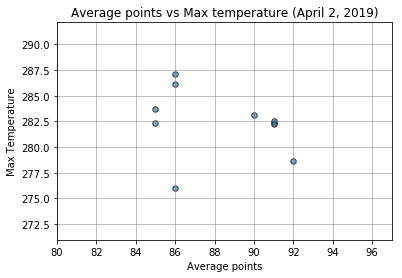

In [123]:
# Build the scatter plot

plt.scatter(weather["av points"],
            weather["temperature"],  
            facecolors="steelblue", edgecolors="black", alpha=0.7,
            label = weather["city"],
            marker= "o", linewidth=1, s= 30)

plt.title("Average points vs Max temperature (April 2, 2019)")
plt.xlabel("Average points")
plt.ylabel("Max Temperature")

plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.xlim(left= weather["av points"].min()-5, right= weather["av points"].max()+5)
plt.ylim(bottom= weather["temperature"].min()-5, top= weather["temperature"].max()+5)

plt.savefig("Average points vs Max temperature (April 2, 2019).png")

# Show plot
plt.show()

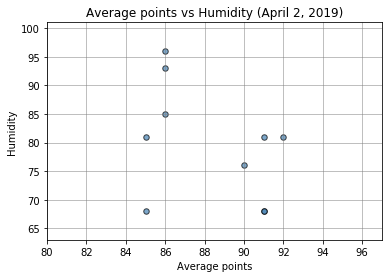

In [124]:
# Build the scatter plot

plt.scatter(weather["av points"],
            weather["humidity"],  
            facecolors="steelblue", edgecolors="black", alpha=0.7,
            label = weather["city"],
            marker= "o", linewidth=1, s= 30)

plt.title("Average points vs Humidity (April 2, 2019)")
plt.xlabel("Average points")
plt.ylabel("Humidity")

plt.grid(color='grey', linestyle='-', linewidth=.5,)
plt.xlim(left= weather["av points"].min()-5, right= weather["av points"].max()+5)
plt.ylim(bottom= weather["humidity"].min()-5, top= weather["humidity"].max()+5)

plt.savefig("Average points vs Humidity (April 2, 2019).png")

# Show plot
plt.show()